In [1]:
import scipy.special
import numpy as np
import itertools
from skimage.segmentation import slic

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import argparse
import time
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation

from PIL import Image

%matplotlib inline

In [2]:
# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--gamma', type=float, default=0.0001, metavar='GAMMA',
                    help='learning rate (default: 0.0001)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')

args, _ = parser.parse_known_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

tr_split_len = 6000
te_split_len = 1000
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
tr = datasets.MNIST('../data', train=True, download=True, transform=trans)
te = datasets.MNIST('../data', train=False, transform=trans)

part_tr = torch.utils.data.random_split(tr, [tr_split_len, len(tr)-tr_split_len])[0]
part_te = torch.utils.data.random_split(te, [te_split_len, len(te)-te_split_len])[0]



In [3]:
def test_WLR(model, test_loader):
    correct = 0
    total = 0
    for i, (data, labels) in enumerate(test_loader):
        data = data.view(data.shape[0], -1)
        X, y = data.to(device), labels.to(device)

        outputs = torch.softmax(model(X), 1)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.to(device)

        total += labels.size(0)
        correct += (predicted == y).sum()

    accuracy = 100 * correct.item() / total
    return accuracy

In [4]:
class WeightedLogisticRegression(torch.nn.Module):
    def __init__(self, M):
        super(WeightedLogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(M, 10)
        nn.init.constant_(self.linear.weight, 0)
        nn.init.constant_(self.linear.bias, 0)
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred


def train_WLR(model, X_train, y_train, train_weight, device, args, optimizer):
    
    model.train()
    criterion = nn.CrossEntropyLoss()
    for i in range(args.epochs):
#         print("in epoch: ", i)
        tw = 0
        loss = 0
        for j in range(len(X_train)):
            data, target = X_train[j], y_train[j]
            data = data.view(1, -1)
            X, y = data.to(device), target.to(device)

            optimizer.zero_grad()

            y_pred = model(X)
            t_weight = train_weight[tw]
            tw += 1
            loss += t_weight * criterion(y_pred, y)
#             print("W = ", t_weight)
#             print("Criterion = ", criterion(y_pred, y))
#             break
        
#         print("loss = ", loss)
        l2reg = torch.trace(torch.mm(model.linear.weight, model.linear.weight.T)) + torch.sum(model.linear.bias ** 2)
        loss += 0.5 * args.gamma * l2reg
#         print("reg loss = ", loss)
        loss.backward()

        optimizer.step()
            
#     print("train accuracy = ", test(model, train_loader))
#     print("test accuracy = ", test_WLR(model, test_loader))
    return model.linear.weight, model.linear.bias

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [8]:
batch_size = 128
num_epochs = 2
device = torch.device('cpu')

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305628
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.215670
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.577923
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.975663
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.654952

Test set: Average loss: 0.0046, Accuracy: 9038/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.704889
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.639123
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.603631
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.397171
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.524700

Test set: Average loss: 0.0025, Accuracy: 9387/10000 (94%)



In [9]:
print(model)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): Dropout(p=0.5, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)


In [10]:
def powerset(iterable, M):
    s = list(iterable)
    set_len = len(s)
    subset_len = [random.randint(0, set_len) for _ in range(M)]
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

def shapley_kernel(M,s):
    if s == 0 or s == M:
        return 100000
    return (M-1)/(scipy.special.binom(M,s)*s*(M-s))

def func(X, model):
    X.clone().detach().requires_grad_(True)
    predict = model(X).max(1, keepdim=True)[1]
    return predict

def mask_image(img, s, feature_list):
    #map the indices of s (the permutaion) to their corresponding feature in feature_list
    feature_map = [feature_list[i] for i in s]
    out = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if i * 28 + j in feature_map:
                out[i][j] = img[i][j]      
    return torch.tensor(out)

In [11]:
def one_finder(number):
    bits = []
    for i, c in enumerate(bin(number)[:1:-1], 1):
        if c == '1':
            bits.append(i - 1)
    return bits

In [11]:
import random
def my_powerset(feature_num, M):
    power_set = []
    set_num = 2 ** feature_num - 1
    while M > 0:
        n = random.randint(0, set_num) 
        indices = one_finder(n)
        power_set.append(indices)
        M -= 1
    return power_set

In [12]:
def kernel_shap(model, x, reference, feature_list, M):
    feature_num = len(feature_list)
    weights = np.zeros(M)
    V = torch.zeros((M, 1, x.shape[0], x.shape[1]))
    X = torch.zeros((M, feature_num))
    for i,s in enumerate(my_powerset(feature_num, M)):
        V[i] = mask_image(x, s, feature_list).view(1, 28, 28)
        X[i, s] = 1
        weights[i] = shapley_kernel(feature_num,len(s))
#         print("____________________________")
#         print(weights[i])
#         print(len(s))
#         print(feature_num)
    y = func(V, model)
    WLR_model = WeightedLogisticRegression(feature_num).to(device)
    args.epochs = 20
    args.lr = 0.01
    args.gamma = 0.0001
    optimizer = torch.optim.SGD(WLR_model.parameters(), lr=args.lr)
    w, b= train_WLR(WLR_model, X, y, weights, device, args, optimizer)
#     w = []
#     b = []
    return w, b

In [49]:
#choosing a sample to explain
for test_images, test_labels in test_loader: 
    sample_image = test_images[0]  
    sample_label = test_labels[0]
    break
    
M = 100000
# feature_num = 28 * 28
mask = np.ones((28, 28))
img = sample_image.reshape((28, 28))

In [50]:
plt.imshow(img.detach().numpy())

In [51]:
feature_list = []
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if img[i][j] > 0:
            feature_list.append(28 * i + j)

In [52]:
start_time = time.time()
shap_values, b = kernel_shap(model, img, mask, feature_list, M)
end_time = time.time()
print("Finished in ", end_time - start_time)

Finished in  477.1477963924408


In [53]:
def fill_segments(img, w, feature_list):
    out = np.zeros((img.shape[0], img.shape[1]))
#     out = img.detach().numpy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] > 0:
                out[i][j] = w[feature_list.index(28 * i + j)]
    return out

In [54]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

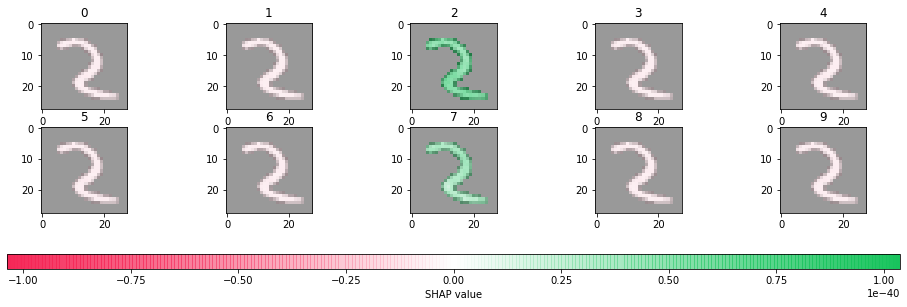

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,5))
max_val = np.max(np.abs(shap_values.detach().numpy()))
trans = transforms.ToPILImage()
for i in range(2):
    for j in range(5):
        axes[i][j].set_title(5 * i + j)
        im = axes[i][j].imshow(fill_segments(img, shap_values[5 * i + j], feature_list), cmap=cm, vmin=-max_val, vmax=max_val)
        axes[i][j].imshow(trans(img).convert('LA'), alpha=0.4)  
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)


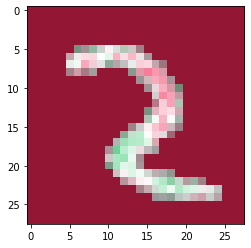

In [57]:
max_val = max(shap_values[2])
min_val = min(shap_values[2])
plt.imshow(fill_segments(img, shap_values[2], feature_list), cmap=cm, vmin=min_val, vmax=max_val)
plt.imshow(trans(img).convert('LA'), alpha=0.4) 

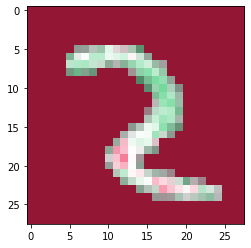

In [58]:
max_val = max(shap_values[7])
min_val = min(shap_values[7])
plt.imshow(fill_segments(img, shap_values[7], feature_list), cmap=cm, vmin=min_val, vmax=max_val)
plt.imshow(trans(img).convert('LA'), alpha=0.4) 

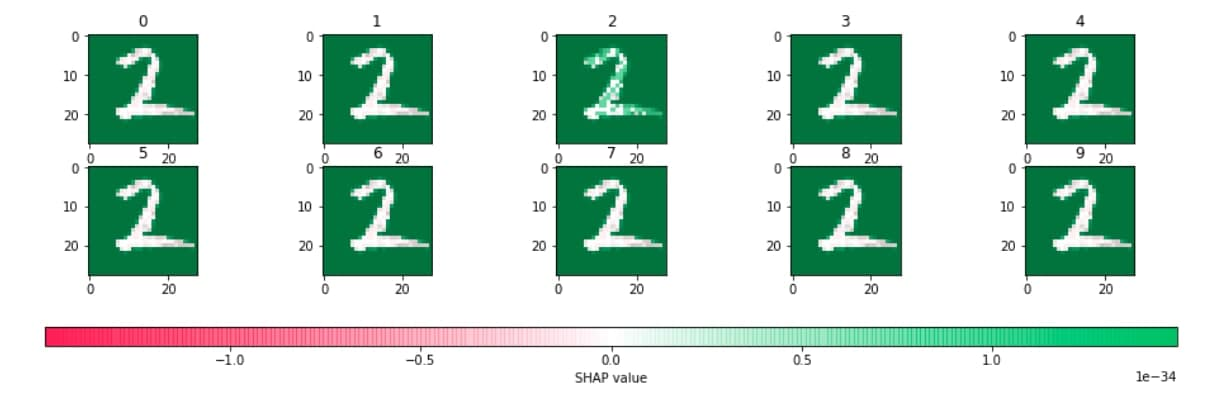

In [268]:
from IPython.display import Image
Image(filename='res.jpg') 

In [271]:
from IPython.display import Image
Image(filename='res2.png') 

In [ ]:
# max_val = max(shap_values[7])
# min_val = min(shap_values[7])

In [ ]:
# print(shap_values[0])

In [291]:
# max_val = max(shap_values[3])
# min_val = min(shap_values[3])
# plt.imshow(fill_segments(img, shap_values[3], feature_list), cmap=cm, vmin=min_val, vmax=max_val)
# plt.imshow(trans(img).convert('LA'), alpha=0.4) 